Add gain method to CrystalSlice class that applies Frantz-Nodvik equation: issue #137
https://github.com/radiasoft/rslaser/issues/137


_________________
Imports

In [11]:
import sys, time
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import drift
from rslaser.optics import crystal

import scipy.constants as const

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

______________
Set laser defaults

In [12]:
# specify parameters
_LASER_PULSE_DEFAULTS = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        nslice = 1,
        nx_slice = 32,
        ny_slice = 32,
)

# Instantiate the default parameters
params = _LASER_PULSE_DEFAULTS.copy()

______________
Define a simple lattice

In [13]:
# instantiate a drift
L_drift = 0.50  # [m]
e_drift = drift.Drift(L_drift)

# instantiate the crystal
crystal_params = PKDict(length = 2.5/100.0,  # [m]
                        nslice = 1,
                        )

______________
Initialize

Text(0.5, 1.0, 'wfr abs efield')

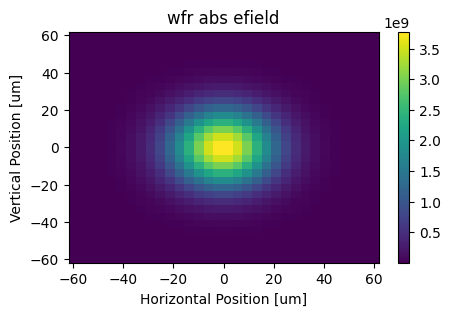

In [14]:
# Initialize crystal and laser pulse
e_crystal = crystal.Crystal(crystal_params)
thisPulse = pulse.LaserPulse(params)

# Plot wavefront
lp_wfr_x = np.linspace(thisPulse.slice[0].wfr.mesh.xStart,thisPulse.slice[0].wfr.mesh.xFin,thisPulse.slice[0].wfr.mesh.nx)
lp_wfr_y = np.linspace(thisPulse.slice[0].wfr.mesh.yStart,thisPulse.slice[0].wfr.mesh.yFin,thisPulse.slice[0].wfr.mesh.ny)

intensity0 = srwlib.array('f', [0]*thisPulse.slice[0].wfr.mesh.nx*thisPulse.slice[0].wfr.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity0, thisPulse.slice[0].wfr, 0, 0, 3, thisPulse.slice[0].wfr.mesh.eStart, 0, 0) #extracts intensity
intens_2d_0 = np.array(intensity0).reshape((thisPulse.slice[0].wfr.mesh.nx, thisPulse.slice[0].wfr.mesh.ny), order='C') #reshaping
efield_abs_2d = np.sqrt(np.sqrt(const.mu_0 / const.epsilon_0) * 2.0 * intens_2d_0) # [V/m]

fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(lp_wfr_x*1e6, lp_wfr_y*1e6, efield_abs_2d, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('wfr abs efield')


________
Interpolate excited state density mesh to match wavefront mesh

Text(0.5, 1.0, 'Temp Density Mesh')

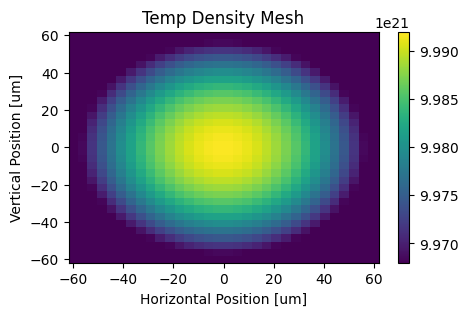

In [15]:
temp_mesh = e_crystal.slice[0]._interpolate_pop_inversion(thisPulse.slice[0].wfr)

# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(lp_wfr_x*1e6, lp_wfr_y*1e6, temp_mesh, cmap=plt.cm.viridis,shading='auto',vmin=9.968e21, vmax=9.992e21)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Temp Density Mesh')


___________
Calcuate gain and change to pop_inversion in notebook

In [16]:
# Calc gain here for comparison with implemented method
cslice_length = e_crystal.slice[0].length            # [m]
absorp_cross_sec = 2.0e-24                           # [m^2] (2.0e-20 cm^2)
degen_factor = 1.0                                   # Not sure what this value should be

wfr0 = thisPulse.slice[0].wfr
dx = (wfr0.mesh.xFin - wfr0.mesh.xStart)/wfr0.mesh.nx
dy = (wfr0.mesh.yFin - wfr0.mesh.yStart)/wfr0.mesh.ny

# total number of incident photons per unit area
#print('Total number photons, initially: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
n_incident_photons = thisPulse.slice[0].n_photons_2d / (dx * dy)   # [1/m^2]

# Note: get error (see below) using format of eq. (17) from the Ph1 final report,
# so multiply out exp*(exp - 1) term
#      RuntimeWarning: overflow encountered in exp
#
# energy_gain = (1.0 /(degen_factor *absorp_cross_sec *n_incident_photons)) \
#                 *np.log(1 +np.exp(absorp_cross_sec *temp_mesh *cslice_length) \
#                 *(np.exp(degen_factor *absorp_cross_sec *n_incident_photons) -1.0))

energy_gain = (1.0 /(degen_factor *absorp_cross_sec *n_incident_photons)) \
                *np.log(1 +np.exp((absorp_cross_sec *temp_mesh *cslice_length) \
                +(degen_factor *absorp_cross_sec *n_incident_photons)) \
                -np.exp(absorp_cross_sec *temp_mesh *cslice_length))

# Update the number of photons
new_n_photons = thisPulse.slice[0].n_photons_2d * energy_gain
#print('Total number photons, post gain: ', np.sum(np.sum(new_n_photons)))

# Update the pop_inversion
#print('Max pop_inversion, initially: ', np.max(e_crystal.slice[0].pop_inversion_mesh))
temp_mesh -= (degen_factor * n_incident_photons * (energy_gain - 1.0) / cslice_length)
#print('Max pop_inversion, post gain: ', np.max(temp_mesh))


In [17]:
e_crystal = crystal.Crystal(crystal_params)
thisPulse = pulse.LaserPulse(params)

print('Total number photons, initially: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, initially: ', np.max(e_crystal.slice[0].pop_inversion_mesh))

temp_mesh = e_crystal.slice[0]._interpolate_pop_inversion(thisPulse.slice[0].wfr)

# Calc gain here for comparison with implemented method
cslice_length = e_crystal.slice[0].length            # [m]
absorp_cross_sec = 2.0e-24                           # [m^2] (2.0e-20 cm^2)
degen_factor = 1.0                                   # Not sure what this value should be

wfr0 = thisPulse.slice[0].wfr
dx = (wfr0.mesh.xFin - wfr0.mesh.xStart)/wfr0.mesh.nx
dy = (wfr0.mesh.yFin - wfr0.mesh.yStart)/wfr0.mesh.ny

# total number of incident photons per unit area
n_incident_photons = thisPulse.slice[0].n_photons_2d / (dx * dy)   # [1/m^2]

energy_gain = (1.0 /(degen_factor *absorp_cross_sec *n_incident_photons)) \
                *np.log(1 +np.exp((absorp_cross_sec *temp_mesh *cslice_length) \
                +(degen_factor *absorp_cross_sec *n_incident_photons)) \
                -np.exp(absorp_cross_sec *temp_mesh *cslice_length))

# Update the number of photons
new_n_photons = thisPulse.slice[0].n_photons_2d * energy_gain
print('Total number photons, post gain: ', np.sum(np.sum(new_n_photons)))

# Update the pop_inversion

temp_mesh_change = -(degen_factor * n_incident_photons * (energy_gain - 1.0) / cslice_length)
temp_mesh_change = e_crystal.slice[0]._interpolate_pop_change(thisPulse.slice[0].wfr,temp_mesh_change)

new_pop_inversion_mesh = e_crystal.slice[0].pop_inversion_mesh + temp_mesh_change
print('Max pop_inversion, post gain: ', np.max(new_pop_inversion_mesh))


Total number photons, initially:  2.8043227e+16
Max pop_inversion, initially:  9.991911811818902e+21
Total number photons, post gain:  2.8043983735667644e+16
Max pop_inversion, post gain:  9.970642526233438e+21


________
Calcuate gain and change to pop_inversion with class function

In [18]:
e_crystal = crystal.Crystal(crystal_params)
thisPulse = pulse.LaserPulse(params)

print('Total number photons, initially: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, initially: ', np.max(e_crystal.slice[0].pop_inversion_mesh))

e_crystal.slice[0].calc_gain(thisPulse.slice[0])

print('Total number photons, post gain: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, post gain: ', np.max(e_crystal.slice[0].pop_inversion_mesh))


Total number photons, initially:  2.8043227e+16
Max pop_inversion, initially:  9.991911811818902e+21
Total number photons, post gain:  2.8043983e+16
Max pop_inversion, post gain:  9.970642526233438e+21


Text(0.5, 1.0, 'Diff Density Mesh')

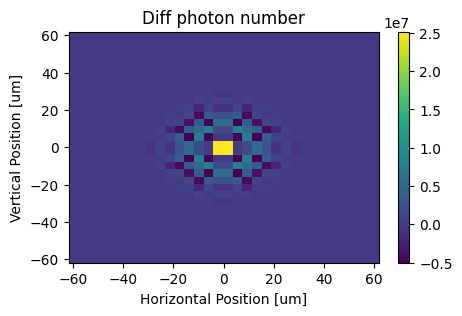

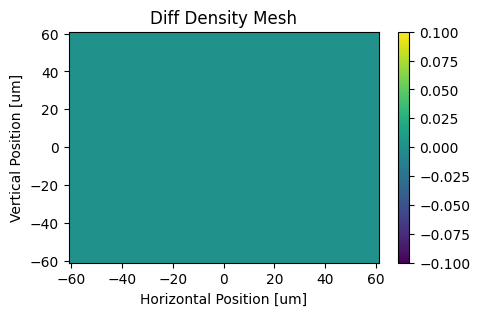

In [19]:
num_photon_diff = new_n_photons - thisPulse.slice[0].n_photons_2d
pop_inver_mesh_diff = new_pop_inversion_mesh - e_crystal.slice[0].pop_inversion_mesh

lp_wfr_x = np.linspace(thisPulse.slice[0].wfr.mesh.xStart,thisPulse.slice[0].wfr.mesh.xFin,thisPulse.slice[0].wfr.mesh.nx)
lp_wfr_y = np.linspace(thisPulse.slice[0].wfr.mesh.yStart,thisPulse.slice[0].wfr.mesh.yFin,thisPulse.slice[0].wfr.mesh.ny)

# plot the diff in photon number
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(lp_wfr_x*1e6, lp_wfr_y*1e6, num_photon_diff, cmap=plt.cm.viridis,shading='auto')
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Diff photon number')

pop_inversion_x = np.linspace(e_crystal.slice[0].pop_inversion_xstart,e_crystal.slice[0].pop_inversion_xfin,e_crystal.slice[0].pop_inversion_nx)
pop_inversion_y = np.linspace(e_crystal.slice[0].pop_inversion_ystart,e_crystal.slice[0].pop_inversion_yfin,e_crystal.slice[0].pop_inversion_ny)

# plot the diff in final population inversion mesh
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(pop_inversion_x*1e6, pop_inversion_y*1e6, pop_inver_mesh_diff, cmap=plt.cm.viridis,shading='auto')
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Diff Density Mesh')

_________
Try propagating laser pulse

In [22]:
e_crystal = crystal.Crystal(crystal_params)
thisPulse = pulse.LaserPulse(params)

print('Total number photons, initially: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, initially: ', np.max(e_crystal.slice[0].pop_inversion_mesh))
print('\n')

# First drift
thisPulse = e_drift.propagate(thisPulse, 'default')

print('Total number photons, 1st drift: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, 1st drift: ', np.max(e_crystal.slice[0].pop_inversion_mesh))
print('\n')

# Through crystal (1 slice for now)
thisPulse = e_crystal.propagate(thisPulse, 'gain_test') #'n0n2_srw')

print('\n')
print('Total number photons, propagate: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, propagate: ', np.max(e_crystal.slice[0].pop_inversion_mesh))
print('\n')

# Last drift
thisPulse = e_drift.propagate(thisPulse, 'default')

print('Total number photons, 2nd drift: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))
print('Max pop_inversion, 2nd drift: ', np.max(e_crystal.slice[0].pop_inversion_mesh))

Total number photons, initially:  2.8043227e+16
Max pop_inversion, initially:  9.991911811818902e+21


Total number photons, 1st drift:  2.8043227e+16
Max pop_inversion, 1st drift:  9.991911811818902e+21


prop_type = gain_test (n0n2_srw)
n0: 1.75, n2: 1.75
Propagated pulse slice  1  of  1


Total number photons, propagate:  2.8043983e+16
Max pop_inversion, propagate:  9.970642526233438e+21


Total number photons, 2nd drift:  2.8043983e+16
Max pop_inversion, 2nd drift:  9.970642526233438e+21


_____________
To do:
* Run for multiple pulse slices and crystal slices
* Find diff in photon number
* Also, add exp(z) to the init calculation of excited states, move some calc_gain params into crystal params
